В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
# def plot_data(X, y):
#     ax = plt.gca()
#     ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)
    
def plot_data(A, b, test = False):
    positive_indices = np.where(b == 1)[0]
    negative_indices = np.where(b == 0)[0]
    
    plt.scatter(A[positive_indices, 0], A[positive_indices, 1], marker='x', c= 'yellow' if test else 'green')
    plt.scatter(A[negative_indices, 0], A[negative_indices, 1], marker='+', c= 'blue' if test else 'red')

In [4]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    # hidden_layer_sizes=(100, 50,)
    def __init__(self, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x):
        self.parameters = {}
        n = len(n_x)
        
        for i in range(1, len(n_x)):
            if (i == n):
                continue
            W = np.random.randn(n_x[i], n_x[i - 1]) * 0.01
            b = np.zeros((n_x[i], 1))
            self.parameters.update({f"W{i}": W, f"b{i}": b})

        W = np.random.randn(1, n_x[n-1]) * 0.01
        b = 0
        
        self.parameters.update({f"W{n}":W, f"b{n}":b})
                    
    def __forward_propagation(self, X):
        num_layers = len(self.hidden_layer_sizes)
        cache = self.parameters.copy()
        
        A = X
        for i in range(1, num_layers + 2):
            W = self.parameters[f"W{i}"]
            b = self.parameters[f"b{i}"]
            Z = np.dot(W, A) + b
            A = self.__sigmoid(Z)
            cache.update({f"Z{i}": Z})
            cache.update({f"A{i}": A})
        return A, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        num_layers = len(self.hidden_layer_sizes)
        
        grads = {}
        
        for i in range(num_layers+1, 0, -1):
            W = cache[f"W{i}"]
            b = cache[f"b{i}"]
            Z = cache[f"Z{i}"]

            if i == num_layers + 1:
                A = cache[f"A{i}"]
                A_next = cache[f"A{i - 1}"]
                
                dZ = A - Y
                dW = 1. / m * np.dot(dZ, A_next.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
                
            elif (i == 1):
                W_prev = cache[f"W{i + 1}"]
                A = cache[f"A{i}"]
                dA = np.dot(W_prev.T, dZ)

                dZ = np.multiply(dA, np.multiply(A, 1 - A))
                dW = 1. / m * np.dot(dZ, X.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            else:
                W_prev = cache[f"W{i + 1}"]
                A = cache[f"A{i}"]
                A_next = cache[f"A{i - 1}"]

                dA = np.dot(W_prev.T, dZ)
                dZ = np.multiply(dA, np.multiply(A, 1 - A))
                dW = 1. / m * np.dot(dZ, A_next.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            grads.update({f"dZ{i}":dZ, f"dW{i}":dW, f"db{i}":db})
        return grads
    
    def __update_parameters(self, grads):
        num_layers = len(self.hidden_layer_sizes)
        
        for i in range(1, num_layers + 2):
            W = self.parameters[f"W{i}"]
            b = self.parameters[f"b{i}"]
            
            dW = grads[f"dW{i}"]
            db = grads[f"db{i}"]
            
            self.parameters[f"W{i}"] = W - self.learning_rate * dW
            self.parameters[f"b{i}"] = b - self.learning_rate * db
            
    def fit(self, X_vert, Y_vert, epsilon=1e-08, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = (X.shape[0],) + self.hidden_layer_sizes
        
        self.__initialize_parameters(n_x)
        
        
        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            costs.append(cost)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))
                if i > 1:
                    print(costs[-2] - costs[-1])

                
            # break condition
            if i > 1 and abs(costs[-2] - costs[-1]) < epsilon:
                print("break")
                break
                
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()

            
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        print(probs)
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [5]:
# data_columns = ["exam1", "exam2"]
# target_column = "submitted"
# df = pd.read_csv("sats.csv")
# X, Y = df[data_columns].values, df[target_column] #.values.reshape((df.shape[0], 1))
# print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [6]:
np.random.seed(1)

data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


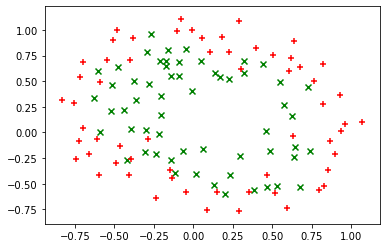

In [7]:
plot_data(X, Y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(94, 2), y=(94,)
Test set: X=(24, 2), y=(24,)


0-th iteration: 0.6932069778426166
1000-th iteration: 0.692241108331832
3.805161741254892e-10
2000-th iteration: 0.6922406063950024
6.71205868663094e-10
3000-th iteration: 0.6922395948537028
1.5011768494943567e-09
4000-th iteration: 0.6922369642196179
4.413350906951052e-09
5000-th iteration: 0.6922270635054881
2.023294232156303e-08
6000-th iteration: 0.6921459129087135
2.507002861973362e-07
7000-th iteration: 0.6860233555229563
1.9048030720503206e-05
8000-th iteration: 0.6671336917577222
3.703655560993724e-05
9000-th iteration: 0.6149513074144309
0.0001549364267977582
10000-th iteration: 0.3421476777887516
6.095093520031014e-05


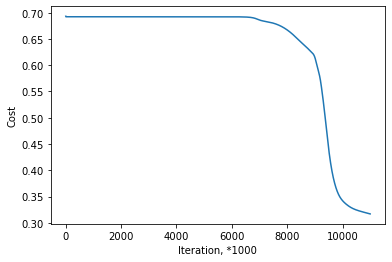

In [9]:
cls = NeuralNet((20, 10), normalize = True, learning_rate = 0.5, num_iter = 11000)
cls.fit(X_train, y_train.values.reshape((X_train.shape[0], 1)), epsilon=1e-15)

In [10]:
print(cls.parameters)

{'W1': array([[ 0.47623115,  0.18359782],
       [ 0.3932404 ,  0.11783947],
       [ 0.4441177 , -0.76146182],
       [ 0.23111933, -2.49045176],
       [-0.85815331, -0.65794137],
       [-1.03673101, -0.54265604],
       [-0.75117513, -0.55820867],
       [-1.06336344, -0.56216503],
       [ 0.29637974,  1.98661763],
       [-0.95363202, -0.51843755],
       [ 0.65748723, -1.43897806],
       [-0.35916393, -0.39277593],
       [ 0.36971439,  0.08998641],
       [-0.98107362, -0.52402367],
       [-1.1743544 , -0.63698694],
       [ 0.44207325,  0.14116269],
       [-0.96404717, -0.51938639],
       [ 0.46628325,  0.18082994],
       [ 0.43336481,  0.13488184],
       [ 0.4387524 ,  0.13445968]]), 'b1': array([[ 0.01592623],
       [-0.10969375],
       [-1.25979781],
       [ 4.65375539],
       [ 0.69555662],
       [ 0.08051515],
       [ 0.5121988 ],
       [ 0.03680552],
       [ 4.77618268],
       [ 0.13808709],
       [ 1.80074066],
       [-0.04614303],
       [-0.17956306],

In [11]:
Y_prob = cls.predict_proba(X_test)
Y_prob

[[0.46642685 0.57254451 0.91422611 0.89307887 0.66767915 0.20717902
  0.70244165 0.05432103 0.20232629 0.09547604 0.97223824 0.27974919
  0.38750598 0.23918166 0.8156746  0.0079801  0.07220132 0.97982931
  0.39664188 0.04590415 0.13725457 0.75627389 0.99281505 0.15183382]]


array([[0.46642685, 0.53357315],
       [0.57254451, 0.42745549],
       [0.91422611, 0.08577389],
       [0.89307887, 0.10692113],
       [0.66767915, 0.33232085],
       [0.20717902, 0.79282098],
       [0.70244165, 0.29755835],
       [0.05432103, 0.94567897],
       [0.20232629, 0.79767371],
       [0.09547604, 0.90452396],
       [0.97223824, 0.02776176],
       [0.27974919, 0.72025081],
       [0.38750598, 0.61249402],
       [0.23918166, 0.76081834],
       [0.8156746 , 0.1843254 ],
       [0.0079801 , 0.9920199 ],
       [0.07220132, 0.92779868],
       [0.97982931, 0.02017069],
       [0.39664188, 0.60335812],
       [0.04590415, 0.95409585],
       [0.13725457, 0.86274543],
       [0.75627389, 0.24372611],
       [0.99281505, 0.00718495],
       [0.15183382, 0.84816618]])

In [12]:
Y_hat = cls.predict(X_test)
Y_hat

[[0.46642685 0.57254451 0.91422611 0.89307887 0.66767915 0.20717902
  0.70244165 0.05432103 0.20232629 0.09547604 0.97223824 0.27974919
  0.38750598 0.23918166 0.8156746  0.0079801  0.07220132 0.97982931
  0.39664188 0.04590415 0.13725457 0.75627389 0.99281505 0.15183382]]


array([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0])

In [13]:
accuracy_score(y_test, Y_hat)

0.875

[[0.00058158 0.00057728 0.00057301 ... 0.0003037  0.00030066 0.00029778]]


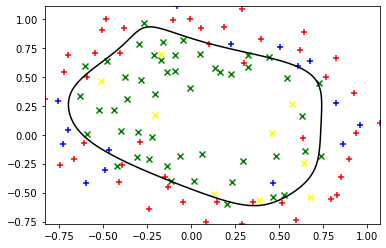

In [14]:
plot_data(X_train, y_train)
plot_data(X_test, y_test, test=True)

plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [19]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 11000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [20]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 10), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=11000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

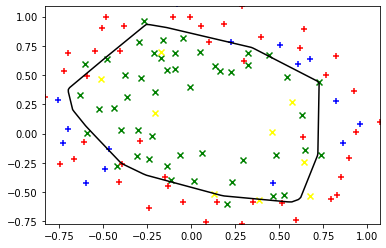

In [21]:
plot_data(X_train, y_train)
plot_data(X_test, y_test, test=True)
plot_surface(clf, X_train[:, 0], X_train[:, 1])

In [22]:
pred = clf.predict(X_test)
accuracy_score(y_test, clf.predict(X_test))

0.7916666666666666

In [70]:
# def softmax(Z):
#         exp_z = np.exp(Z)
#         return exp_z / exp_z.sum(axis=0, keepdims=True)

# def compute_cost(A, Y):
#     J = -np.mean(Y.T * np.log(A.T))
#     return J

# W = np.array([[0.1, 0.2, 0.3], [0.4, 0.3, 0.2]])
# b = np.array([[0], [1]])
# A = np.array([[0.3],[0.5],[0.2]])


# Y = np.array([[0, 1, 0, 0], [1, 0, 0, 1], [0, 0, 1, 0]])
# A = np.array([[0.01, 0.82, 0.65, 0.01], [0.93, 0.14, 0.21, 0.1], [0.06, 0.04, 0.14, 0.89]])
# print(A.shape)
# print(Y.shape)
# compute_cost(A, Y)


# t = [10, 2, 8, 5, 3]
# s = np.std(t)**2
# m = np.mean(t)

# t = (t - m) / s

# t


# dZ = A - Y 
# db = 1./4 * np.sum(dZ, axis = 1, keepdims = True)
# print(db)

coef = 0.5
T = np.array([14, 20, 15, 14, 10, 12, 17])

T0 = 0
T_new = []

for el in T:
    T1 = el
    print(T0, T1)
    new_el = coef * T0 + (1 - coef) * T1
    T_new.append(new_el)
    T0 = new_el
print(T_new)
print(T)


# Tf = 25 / 150
# Idf = np.log10(3000 / 150) 

# Tf * Idf


0 14
7.0 20
13.5 15
14.25 14
14.125 10
12.0625 12
12.03125 17
[7.0, 13.5, 14.25, 14.125, 12.0625, 12.03125, 14.515625]
[14 20 15 14 10 12 17]
